In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import gc
import tqdm
import datetime
import random
from collections import defaultdict
from sklearn.neural_network import MLPRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

from sklearn.ensemble import RandomForestRegressor

# model
import xgboost as xgb
import lightgbm as lgb

# evaluation
from sklearn.metrics import mean_squared_error

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = 'drive/My Drive/11dacon/data/'

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
from numba import jit
import math

@jit
def smape_fast(y_true, y_pred, exp=False):
    
    if exp:
        y_true = np.expm1(np.array(y_true))
        y_pred = np.expm1(np.array(y_pred))
    else:
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

def rmse(y_true, y_pred, exp=False):
    if exp:
        return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
    else:
        return np.sqrt(mean_squared_error(y_true, y_pred))

In [0]:
test = pd.read_csv(path+'test.csv')
sub = pd.read_csv(path+'submission.csv')

In [0]:
def merge(train, col):
    temp = train[['Time', col]].dropna().rename(columns={col:'target'})
    temp = temp[temp['Time']>='2017-11-23'].reset_index(drop=True)
    
    temp['Time'] = pd.to_datetime(temp['Time'])
    temp['month'] = temp['Time'].dt.month
    temp['week'] = temp['Time'].dt.week
    temp['weekday'] = temp['Time'].dt.weekday
    temp['day'] = temp['Time'].dt.day
    temp['hour'] = temp['Time'].dt.hour
    for i in range(24):
        temp.loc[temp['hour']==i, 'target'] = temp.loc[temp['hour']==i, 'target'].clip(0, 
                                                                                       temp.loc[temp['hour']==i, 'target'].mean() + 3*temp.loc[temp['hour']==i, 'target'].std())
    temp = temp.dropna().reset_index(drop=True)

    temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:-1, :]
    temp2['Time'] = pd.to_datetime(temp2['Time'])
    temp2['month'] = temp2['Time'].dt.month
    temp2['week'] = temp2['Time'].dt.week
    temp2['weekday'] = temp2['Time'].dt.weekday
    temp2['day'] = temp2['Time'].dt.day
    temp2['hour'] = temp2['Time'].dt.hour

    return temp, temp2

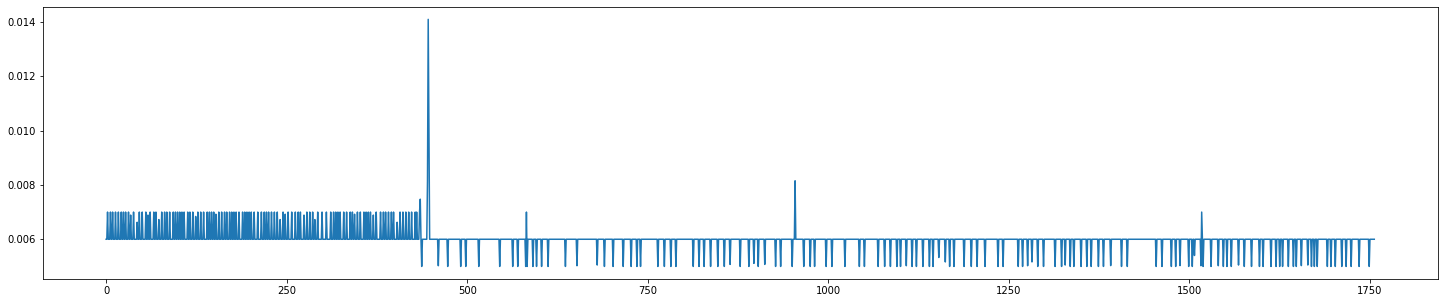

In [43]:
plt.figure(figsize=())
plt.plot(train_df['target'])

In [44]:
train_df['target'].value_counts()

0.006000    1505
0.005000     111
0.007000     103
0.005026       6
0.006889       4
0.005052       4
0.005031       3
0.006921       3
0.006725       3
0.005074       2
0.006625       2
0.005165       2
0.006839       1
0.005330       1
0.009764       1
0.005403       1
0.008129       1
0.008150       1
0.014088       1
0.005114       1
0.007474       1
Name: target, dtype: int64

In [51]:
SEED=42
seed_everything(SEED)

params = {
    'objective':'regression',
    'boosting_type':'gbdt',
    'metric':'rmse',
    'n_jobs':-1,
    'learning_rate':0.03,
    'num_leaves': 500,#2**9,
    'max_depth':-1,
    'tree_learner':'serial',
    'min_child_weight':5, 
    'subsample':0.7,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'verbose':-1,
    'seed': SEED
}
    
rmse_list = []
smape_list = []
submit_dict = defaultdict()

target_arr = np.array([])
oof_arr = np.array([])

for idx in tqdm.tqdm_notebook(list(range(200))):
    train_df, test_df = merge(test, sub['meter_id'][idx])

    oof = np.zeros(len(train_df))
    pred = np.zeros(len(test_df))
    
    feature = [i for i in train_df.columns if i not in ['target', 'Time']]
    kf = KFold(n_splits=5, random_state=2019, shuffle=True)

    for trn_idx, val_idx in kf.split(train_df):
        tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
        vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])

        model = lgb.train(params, tt, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0)

        oof[val_idx] = model.predict(train_df.loc[val_idx, feature])
        pred += model.predict(test_df[feature])/5
    oof[oof<0] = 0
    pred[pred<0] = 0
    
    target_arr = np.concatenate([target_arr, train_df['target'].values])
    oof_arr = np.concatenate([oof_arr, oof])
    print(idx, smape_fast(target_arr, oof_arr), rmse(target_arr, oof_arr), smape_fast(train_df['target'], oof), rmse(train_df['target'], oof))
    
    # 할당
    rmse_list.append(rmse(train_df['target'], oof))
    smape_list.append(smape_fast(train_df['target'], oof))
    submit_dict[idx] = pred

0 4.37428456497013 0.32109419638481457 4.37428456497013 0.32109419638481457
1 11.435037874562273 0.3391804399519298 18.495791184154434 0.3563499105373249
2 11.81763783244233 0.4980080012708746 12.582837748202419 0.7169024803259261
3 11.124238339074333 0.5167827628408852 9.044039858970368 0.5694047663028473
4 9.091549070195741 0.46249598142578907 0.9607919946814362 0.0354255317135086
5 11.30829717214906 0.4360739851336014 22.392037681916005 0.2673021864609108
6 11.607206540990791 0.4179126180902173 13.400662754041148 0.2856458847092602
7 14.428281265826232 0.6740739011587182 34.17580433967441 1.5532058135590172
8 13.570763206686047 0.6356627088875474 6.710618733564706 0.03998401487627458
9 14.232822684548315 0.6040978276927622 20.191357985308393 0.11286336428996253
10 13.16704771542996 0.575984693798788 2.5092980242464127 0.0004337789501942818
11 13.233806237827364 0.6204560643958228 13.968149984199224 0.9850110109797359
12 14.349912387940176 0.62653917821857 27.743186189293716 0.695398

In [53]:
np.mean(rmse_list), np.mean(smape_list)

(0.2524068450074558, 28.595842883689308)

In [0]:
submit_df = pd.concat([pd.DataFrame(submit_dict).loc[:23], 
                       pd.concat([pd.DataFrame([j for i in range(10) for j in str(i) * 24], columns=['house']), pd.DataFrame(submit_dict).loc[:239]], 1).groupby('house').sum().reset_index(drop=True),
                       pd.concat([test_df['Time'].dt.to_period('m'), pd.DataFrame(submit_dict)], 1).groupby('Time').sum().reset_index(drop=True)])

In [0]:
submit_df.columns = sub['meter_id']
submit_df = submit_df.T.reset_index()
submit_df.columns = sub.columns

In [0]:
제출 점수 : 30.3

In [56]:
submit_df.head(15)

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,X2018_7_1_10h,X2018_7_1_11h,X2018_7_1_12h,X2018_7_1_13h,X2018_7_1_14h,X2018_7_1_15h,X2018_7_1_16h,X2018_7_1_17h,X2018_7_1_18h,X2018_7_1_19h,X2018_7_1_20h,X2018_7_1_21h,X2018_7_1_22h,X2018_7_1_23h,X2018_7_1_24h,X2018_7_1_d,X2018_7_2_d,X2018_7_3_d,X2018_7_4_d,X2018_7_5_d,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,5.978444,5.928207,5.894050,5.888138,5.849234,5.599988,5.622065,5.924241,5.978995,6.165978,6.153579,6.163243,6.206007,6.182435,6.160598,6.165799,6.234495,6.294355,6.289381,6.334963,6.323226,6.317562,6.290957,6.167831,146.113772,143.563546,145.120764,144.813283,145.348417,146.319585,143.851102,144.609939,141.932814,141.843419,4521.301095,4517.661086,4374.175698,4516.794112,4368.961372
1,X7,1.141392,1.154269,1.144798,1.146472,1.164323,1.173690,1.232241,2.330759,2.800029,2.800404,2.802781,2.872089,3.033384,2.973629,2.912505,2.907550,2.899858,2.892510,2.752066,1.436769,1.218594,1.203172,1.190984,1.189414,48.373681,33.642957,31.836561,32.627488,37.503941,43.238625,47.625144,48.157445,34.183574,32.919867,1232.415364,1227.828489,1212.437846,1212.947632,1195.744265
2,X10,2.309741,2.309741,2.305841,2.305841,2.305841,2.309754,2.312919,5.242587,6.849480,6.697786,6.706676,6.871684,8.224054,8.274250,8.050071,7.928733,7.245217,6.841427,6.959108,4.205072,2.700091,2.604052,2.604052,2.604052,116.768067,50.175778,69.862838,67.869302,65.441742,103.215507,114.967306,116.002597,49.137914,64.117375,2554.681086,2535.083552,2558.563360,2495.269971,2474.463651
3,X16,3.317978,3.316063,3.298945,3.296983,3.296168,3.330152,3.474191,3.671317,4.012102,4.502274,4.968265,5.566269,7.333437,7.334381,5.554617,5.209996,5.124314,5.094083,5.293797,5.367405,5.136084,4.436441,3.473095,3.400650,108.809009,96.092196,96.622244,93.610435,95.463049,104.106782,110.480380,110.467410,96.469684,96.609230,3221.295619,3215.311186,3141.043555,3200.919114,3114.664168
4,X18,2.555352,2.555352,2.555815,2.558567,2.563671,2.568210,2.801036,2.716950,2.642842,2.632288,2.631389,2.630143,2.624952,2.624587,2.623957,2.623891,2.623580,2.617042,2.511360,2.507528,2.509843,2.517887,2.518931,2.519005,62.234178,59.859804,59.899402,59.902377,60.019163,62.236202,62.497372,62.382645,60.192284,60.231902,1886.552802,1886.080178,1829.343751,1883.950799,1825.997739
5,X20,0.329732,0.329732,0.329732,0.329732,0.328990,0.325642,0.335127,0.337403,0.348931,0.361783,0.405629,0.632296,0.688852,0.744967,0.658887,0.629955,0.614662,0.653990,0.773918,0.792247,0.788591,0.768552,0.691105,0.691105,12.891561,14.781972,10.842933,9.576251,10.446601,11.310003,12.890623,12.891561,14.781972,10.843387,377.911790,373.721440,362.835653,377.179953,358.875909
6,X26,1.223575,1.222441,1.220717,1.219712,1.103446,1.234898,1.024175,0.997384,1.060264,1.265011,1.268753,1.251582,1.197733,1.197447,1.172000,1.166971,1.162242,1.154703,1.182686,1.185735,1.165928,1.164465,1.262418,1.174339,28.278627,27.158558,35.463752,37.451252,36.582193,33.954085,30.652319,29.783350,26.873189,34.506594,1013.045403,1023.874530,985.080239,1024.934500,986.357105
7,X30,1.871618,1.254743,1.018389,1.018389,0.998115,0.997167,1.004830,1.011867,1.008001,1.093223,4.049649,5.413397,5.910675,6.127712,6.102097,6.013446,5.778950,5.394355,5.004429,5.001775,4.991709,4.616458,4.646498,3.611017,83.938509,98.789423,104.738026,110.643517,105.486331,112.449074,134.513516,81.324419,94.694842,100.935519,3162.466070,3177.664857,3072.802942,3184.129591,3064.292710
8,X31,0.276525,0.338815,0.359315,0.359277,0.359066,0.482419,0.504193,0.535709,0.543736,0.550237,0.556767,0.556094,0.554373,0.557387,0.570584,0.571667,0.567861,0.555195,0.545172,0.530650,0.521086,0.514946,0.502262,0.351194,11.764530,11.883883,11.866797,11.882837,11.674903,11.685621,11.735744,11.665168,11.875064,11.806697,360.392654,359.756675,348.737817,360.408170,348.173851
9,X32,0.266341,0.231199,0.211478,0.211478,0

In [57]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/11dacon/submit/'

submit_df.to_csv(path+'friday_lgb_score.csv', index=False)

Mounted at /content/drive


In [30]:
submit_df.head(15)

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,X2018_7_1_10h,X2018_7_1_11h,X2018_7_1_12h,X2018_7_1_13h,X2018_7_1_14h,X2018_7_1_15h,X2018_7_1_16h,X2018_7_1_17h,X2018_7_1_18h,X2018_7_1_19h,X2018_7_1_20h,X2018_7_1_21h,X2018_7_1_22h,X2018_7_1_23h,X2018_7_1_24h,X2018_7_1_d,X2018_7_2_d,X2018_7_3_d,X2018_7_4_d,X2018_7_5_d,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,5.992953,5.929570,5.905295,5.902664,5.889697,5.674291,5.690095,6.036037,6.048437,6.236965,6.217151,6.236791,6.242125,6.221173,6.201193,6.201389,6.289521,6.319524,6.308933,6.349852,6.325049,6.319606,6.308678,6.220473,147.067463,144.041552,145.075530,144.461654,144.736430,146.080871,144.571786,145.558807,143.111792,142.532969,4533.780590,4529.724901,4387.330494,4529.645893,4381.219540
1,X7,1.134418,1.159497,1.148888,1.151001,1.162569,1.165122,1.207679,2.227417,2.713915,2.704747,2.710647,2.785670,2.936579,2.893162,2.854443,2.835596,2.822662,2.806277,2.674724,1.396087,1.185276,1.179202,1.174324,1.169609,47.199511,34.004741,32.314933,33.013249,37.805759,43.079356,46.425993,47.023048,34.485483,33.133347,1227.473764,1223.600671,1207.036728,1208.828982,1190.848029
2,X10,2.299384,2.299384,2.297645,2.297645,2.298772,2.296808,2.304776,5.171509,6.800671,6.729773,6.727723,6.795515,8.064307,8.260747,8.010402,7.973405,7.197682,6.826205,6.974549,4.278653,2.723977,2.631844,2.632427,2.632427,116.526231,49.274438,69.381375,67.205895,65.153553,103.795235,115.213083,116.302402,48.632743,64.727615,2555.037162,2534.873452,2557.757699,2498.062941,2474.951829
3,X16,3.248346,3.245678,3.239314,3.239263,3.236292,3.235224,3.419587,3.670894,3.914282,4.481064,4.982386,5.592080,7.282333,7.282333,5.557537,5.268019,5.157947,5.143936,5.303996,5.362986,5.127981,4.408303,3.468698,3.421190,108.289667,95.864724,96.956461,93.866300,95.858339,104.215515,110.530222,110.386691,96.121478,96.535779,3223.831495,3216.878646,3144.500064,3202.558410,3118.127390
4,X18,2.555615,2.555615,2.556315,2.558154,2.561212,2.567936,2.797159,2.723091,2.645537,2.632796,2.630933,2.629712,2.627150,2.627296,2.627213,2.626554,2.625276,2.618334,2.509065,2.505611,2.507886,2.515057,2.516786,2.516786,62.237090,59.911463,59.958987,59.970230,60.070727,62.326547,62.470046,62.412674,60.200058,60.250660,1887.132331,1886.843168,1829.957461,1884.580086,1826.768140
5,X20,0.297883,0.297883,0.297636,0.297636,0.296776,0.296730,0.299243,0.299243,0.302498,0.336242,0.393735,0.665183,0.808513,0.834510,0.695674,0.630363,0.626247,0.648177,0.861658,0.971349,0.966013,0.934971,0.858572,0.858572,13.775307,16.543422,12.328465,11.410128,13.197881,12.908886,13.736872,13.775307,16.560066,12.364290,424.999884,422.781083,406.884106,423.296065,405.237739
6,X26,1.233854,1.233854,1.232442,1.232050,1.103002,1.214832,1.036655,1.033464,1.110603,1.270579,1.274808,1.253159,1.207813,1.201398,1.196316,1.175826,1.174499,1.189581,1.181335,1.185057,1.185262,1.175802,1.233910,1.158749,28.494851,27.088717,35.009685,36.989086,36.744618,34.979753,30.816159,30.218621,26.923373,34.598663,1014.998229,1027.864766,989.177125,1026.490190,991.109775
7,X30,1.915419,1.225130,1.014599,1.013823,0.988442,0.986080,0.990367,0.995083,1.001315,1.065025,3.972943,5.041866,5.567244,5.987824,5.988330,5.928267,5.733979,5.450761,5.203394,5.203536,5.175985,4.696109,4.802957,3.659121,83.607599,102.070836,108.521205,111.706576,101.973901,110.661116,133.953844,81.227381,97.400984,103.700957,3166.400438,3185.741707,3079.539526,3189.281456,3074.896170
8,X31,0.278661,0.342704,0.359169,0.359036,0.358311,0.480381,0.505238,0.538882,0.545706,0.552353,0.558172,0.557270,0.555105,0.559212,0.570644,0.573146,0.570577,0.557370,0.551980,0.535758,0.522844,0.512806,0.501902,0.352982,11.800211,11.907898,11.862252,11.908109,11.693127,11.687638,11.768800,11.684627,11.908954,11.814392,360.587398,360.089094,348.876606,360.624568,348.443845
9,X32,0.268120,0.230884,0.212741,0.212741